In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from mpl_toolkits.axes_grid1.colorbar import colorbar

'''
En este script vamos a simular la ecuacion de swift-hohenberg con acoplamiento traslacional:

du/dt = eps * u(x+L) - u(x+L)**3 - d**2 u/dx**2 - d**4 u/dx**4 

'''
##Parametros de la ecuacion

eps = -.3
l = 1.35

##Parametros de la simulacion

dx = 1.0
dt = .1

L = 50
x = np.arange(0,L, dx)
xx = np.arange(0,2*L, dx) 
n = len(x)

### Canvas, aqui dibujaremos la simulacion
Canvas = np.zeros((n,n))

## Calcula la segunda derivada en el espacio de un campo escalar
def laplacian(vector):
    laplacian = (np.roll(vector, -1) - 2*vector + np.roll(vector, 1))/dx**2
    return laplacian

## Calcula la cuarta derivada en el espacio de un campo escalar
def bilaplacian(vector):
    bilaplacian = (np.roll(vector, -2) - 4*np.roll(vector, -1) + 6*vector - 4*np.roll(vector, 1) + np.roll(vector, 2))/dx**4
    return bilaplacian

def laplacian_null_border(vector):
    vector[0] = 0
    vector[-1] = 0
    laplacian = (np.roll(vector, -1) - 2*vector + np.roll(vector, 1))/dx**2
    return laplacian

## Calcula la cuarta derivada en el espacio de un campo escalar
def bilaplacian_null_border(vector):
    vector[0] = 0
    vector[-1] = 0
    vector = np.concatenate([vector, [0]])
    vector = np.concatenate([[0],vector])
    bilaplacian = (np.roll(vector, -2) - 4*np.roll(vector, -1) + 6*vector - 4*np.roll(vector, 1) + np.roll(vector, 2))/dx**4
    return bilaplacian[1:-1]

### Desplaza la funcion u en l
def shift(u_actual, l):
    uu = np.concatenate([u_actual, u_actual])
    u = interp1d(xx, uu , kind='cubic')
    x_new = x + l
    return u(x_new)

def shift_null_border(u_actual, l):
    zeros = np.zeros(len(u_actual))
    uu = np.concatenate([u_actual, zeros])
    u = interp1d(xx, uu , kind='cubic')
    x_new = x + l
    return u(x_new)

def equation(u_actual,eps, l):
    u_tilda = shift(u_actual, l)
    return eps*u_tilda - np.float_power(u_tilda,3) - laplacian(u_actual) - bilaplacian(u_actual)

def equation_null_border(u_actual,eps, l):
    u_actual[0] = 0
    u_actual[-1] = 0
    u_tilda = shift_null_border(u_actual, l)
    return eps*u_tilda - np.float_power(u_tilda,3) - laplacian_null_border(u_actual) - bilaplacian_null_border(u_actual)

#Avanza en un dt la EDP
def time_step(u_actual, eps, l):
    k1 = equation(u_actual, eps, l)
    k2 = equation(.5*k1*dt,eps,l)
    k3 = equation(.5*k2*dt,eps,l)
    k4 = equation(k3*dt,eps,l)
    return u_actual + dt/6.0*(k1+ 2*k2 + 2*k3 + k4)

#Avanza en un dt la EDP
def time_step_null_border(u_actual, eps, l):
    k1 = equation_null_border(u_actual, eps, l)
    k2 = equation_null_border(.5*k1*dt,eps,l)
    k3 = equation_null_border(.5*k2*dt,eps,l)
    k4 = equation_null_border(k3*dt,eps,l)
    return u_actual + dt/6.0*(k1+ 2*k2 + 2*k3 + k4)

def tangent_map(u_actual, eps, l):
    n = len(u_actual)
    u_tilda = shift(u_actual, l)
    
    I = np.identity(n)
    I1 = np.roll(I, 1, axis=1)
    I2 = np.roll(I, 2, axis=1)
    I_1 = np.roll(I, -1, axis=1)
    I_2 = np.roll(I, -2, axis=1)
    diag = np.diag(eps + 2/dx**2 - 6/dx**4 - 3*u_tilda**2)
    
    return diag + (-1/dx**2 + 4/dx**4)*(I1+I_1) - 1/dx**4*(I2+I_2)


    
## Calculo de la simulacion
u_inicial = np.random.rand(n)
u_inicial[0] = 0
u_inicial[-1] = u_inicial[0]
u_actual = u_inicial

#w_inicial = np.random.rand(n)/np.linalg.norm(w)
#w = w_inicial
#mlce = np.zeros(n)
#alpha = np.ones(n)

times = 250

for _ in range(5000):
    u_actual = time_step_null_border(u_actual,eps, l)


print 'Transiente terminado'

for i in range(n):
    for _ in range(times):
        u_actual = time_step_null_border(u_actual, eps, l)
    Canvas[i,:] = u_actual

envelope = np.abs(hilbert(Canvas))


 

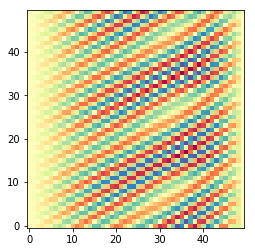

"\nfig = plt.figure(figsize = (110,47))\nax1 = fig.add_subplot(211)\nax2 = fig.add_subplot(221)\n\nim1 = ax1.imshow(envelope, aspect='equal', cmap='summer', origin='lower')\nax1.set_xlabel(r'$x$', fontsize=45, x = .95)\nax1.set_ylabel(r'$t$', fontsize=45, y = .9, rotation=0)\nax1.text(400,430 , r'$\x0barepsilon = $'+ str(eps) +'\n'+ r'$L = $'+str(l)+'\n'+ r'$\nu = $'+str(1.0),fontsize=45, \n         bbox=dict(facecolor='white', alpha=0.8))\n#ax1.set_title(r'Envolvente del campo $u(x,t)$', fontsize=45, y=-0.05)\n\n#ax2.text(250,470 , r'$\\partial_t u = \x0barepsilon \tilde{u} - \tilde{u}^3 - \nu \\partial_x^2u - \\partial_x^4 u$',fontsize=45, \n         #bbox=dict(facecolor='white', alpha=0.8))\ncb1=plt.colorbar(im1)\n\nim2 = ax2.imshow(Canvas, aspect='equal', cmap='Spectral', origin='lower')\nax2.set_xlabel(r'$x$', fontsize=45, x = .95)\nax2.set_ylabel(r'$t$', fontsize=45, y = .9, rotation=0)\n#ax2.set_title(r'Campo $u(x,t)$', fontsize=45, y = -.05)\nplt.show()\n"

In [25]:
fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

#im1 = ax1.imshow(envelope, cmap='summer', origin='lower')
#ax1.set_xlabel(r'$x$', x = .95)
#ax1.set_ylabel(r'$t$', y = .9, rotation=0)
#ax1.text(400,430 , r'$\varepsilon = $'+ str(eps) +'\n'+ r'$L = $'+str(l)+'\n'+ r'$\nu = $'+str(1.0),fontsize=45, 
         #bbox=dict(facecolor='white', alpha=0.8))
#ax1.set_title(r'Envolvente del campo $u(x,t)$', fontsize=45, y=-0.05)

#ax2.text(250,470 , r'$\partial_t u = \varepsilon \tilde{u} - \tilde{u}^3 - \nu \partial_x^2u - \partial_x^4 u$',fontsize=45, 
         #bbox=dict(facecolor='white', alpha=0.8))
#cb1=plt.colorbar(im1)

im2 = ax2.imshow(Canvas,cmap='Spectral', origin='lower')
#ax2.set_xlabel(r'$x$', x = .95)
#ax2.set_ylabel(r'$t$', y = .9, rotation=0)
#ax2.set_title(r'Campo $u(x,t)$', fontsize=45, y = -.05)
plt.show()

'''
fig = plt.figure(figsize = (110,47))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(221)

im1 = ax1.imshow(envelope, aspect='equal', cmap='summer', origin='lower')
ax1.set_xlabel(r'$x$', fontsize=45, x = .95)
ax1.set_ylabel(r'$t$', fontsize=45, y = .9, rotation=0)
ax1.text(400,430 , r'$\varepsilon = $'+ str(eps) +'\n'+ r'$L = $'+str(l)+'\n'+ r'$\nu = $'+str(1.0),fontsize=45, 
         bbox=dict(facecolor='white', alpha=0.8))
#ax1.set_title(r'Envolvente del campo $u(x,t)$', fontsize=45, y=-0.05)

#ax2.text(250,470 , r'$\partial_t u = \varepsilon \tilde{u} - \tilde{u}^3 - \nu \partial_x^2u - \partial_x^4 u$',fontsize=45, 
         #bbox=dict(facecolor='white', alpha=0.8))
cb1=plt.colorbar(im1)

im2 = ax2.imshow(Canvas, aspect='equal', cmap='Spectral', origin='lower')
ax2.set_xlabel(r'$x$', fontsize=45, x = .95)
ax2.set_ylabel(r'$t$', fontsize=45, y = .9, rotation=0)
#ax2.set_title(r'Campo $u(x,t)$', fontsize=45, y = -.05)
plt.show()
'''

In [144]:
i=0
for line in Canvas[0:100]:
    plt.clf()
    plt.figure(figsize=(10,3))
    plt.plot(x, line)
    plt.xlabel(r'$x$', x=.95, fontsize=15)
    plt.ylabel(r'$u(x,t)$', y = 1, fontsize=15, rotation=0)
    plt.ylim((-.6,.6))
    plt.savefig('gif\intermitency_'+str(i)+'.png')
    i = i+1

C:\Users\Asus\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


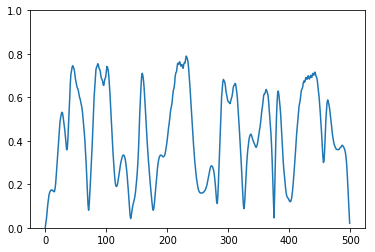

In [25]:
j = 0
for line in envelope:
    plt.clf()
    plt.plot(x, line)
    plt.savefig('sim\im'+str(j)+'.png')
    plt.ylim((0, 1.0))
    j = j+1
    print j



In [11]:
def tangent_map(u_actual):
    n = len(u_actual)
    u_tilda = shift(u_actual, l)
    
    I = np.identity(n)
    I1 = np.roll(I, 1, axis=1)
    I2 = np.roll(I, 2, axis=1)
    I_1 = np.roll(I, -1, axis=1)
    I_2 = np.roll(I, -2, axis=1)
    diag = np.diag(eps + 2/dx**2 - 6/dx**4 - 3*u_tilda**2)
    
    return diag + (-1/dx**2 + 4/dx**4)*(I1+I_1) - 1/dx**4*(I2+I_2)




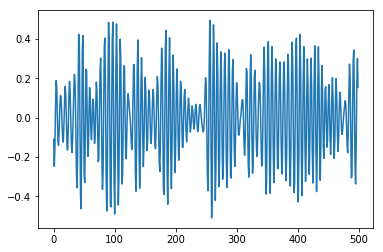

In [28]:
plt.plot(x, np.abs(u_actual)

In [27]:
range(1)

[0]